In [ ]:
!pip install catboost

**Tools**

In [ ]:
import pandas as pd
import numpy as np
import random as rnd
import catboost
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

from google.colab import files

**Downloading of Kaggle data**

In [ ]:
!pip install -q kaggle

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andreylib","key":"0db48ab3ea164b198af958b08c6e55fd"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 57.3MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 25.2MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.26MB/s]


In [ ]:
%ls

kaggle.json  sample_data/


**Functions**

In [ ]:
def get_columns_with_missing_values(df):
  return df.columns[df.isna().any()].tolist()

In [ ]:
def get_and_draw_importances(X_train, importances):
  indices = np.argsort(importances)
  plt.figure(figsize = (15, 25))
  plt.title("Feature importances")
  plt.barh(range(X_train.shape[1]), importances[indices], color="r", align="center")
  plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
  plt.ylim([-1, X_train.shape[1]])
  plt.show()
  return X_train.columns[indices]

**Preprocessing**

In [ ]:
def get_ticket_class(x):
  prefix = x[:2]
  if prefix[0] in ('1', '2', '3', '4', '5', '6', '7', '8', '9'):
    return prefix[0]
  else:
    return prefix

In [ ]:
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

In [ ]:
def get_title(x):
  pos1 = x.find(',')
  pos2 = x.find('.')
  return normalized_titles[x[pos1 + 2: pos2]]

In [ ]:
def change_ticket_class(ticket):
  if ticket in ('1', '2', '3', 'PC', 'A/'):
    return ticket
  else:
    return 'rest'

In [ ]:
def preprocessing(df):
  df_res = df.copy()

  df_res['Sex'] = df_res['Sex'].apply(lambda x: 1 if x == 'male' else 0)

  df_res['SibSp + Parch'] = df_res['SibSp'] + df_res['Parch']

  df_res['Title'] = df_res['Name'].apply(get_title)

  df_res['Age'] = df_res['Age'].fillna(df_res.groupby(['Pclass', 'Title', 'Sex'])['Age'].transform('mean'))

  df_res['Ticket_class'] = df_res['Ticket'].apply(get_ticket_class)

  df_res = pd.concat([df_res, pd.get_dummies(data = df_res['Pclass'], prefix = 'Pclass')], axis = 1)

  df_res = pd.concat([df_res, pd.get_dummies(data = df_res['Title'], prefix = 'Title')], axis = 1)

  most_freq = df_res['Embarked'].mode()
  df_res['Embarked'] = df_res['Embarked'].fillna(most_freq[0])
  df_res = pd.concat([df_res, pd.get_dummies(data = df_res['Embarked'], prefix = 'Embarked')], axis = 1)

  df_res['Ticket_class'] = df_res['Ticket_class'].apply(change_ticket_class)
  df_res = pd.concat([df_res, pd.get_dummies(data = df_res['Ticket_class'], prefix = 'Ticket_class')], axis = 1)

  avg_fare = df_res['Fare'].mean()
  df_res['Fare'] = df_res['Fare'].fillna(avg_fare)

  df_res['Cabin'] = df_res['Cabin'].fillna('U').apply(lambda x: x[0])
  df_res = pd.concat([df_res, pd.get_dummies(data = df_res['Cabin'], prefix = 'Cabin')], axis = 1)

  df_res = df_res.drop(columns = ['Ticket', 'Name', 'Cabin', 'Title', 'Embarked', 'Ticket_class', 'Pclass', 'SibSp', 'Parch'])

  return df_res

In [ ]:
train_df = pd.read_csv(r"train.csv")
test_df = pd.read_csv(r"test.csv")

data_df = pd.concat([train_df.drop(columns = ['Survived']), test_df], axis = 0)

In [ ]:
data_df_preprocessed = preprocessing(data_df)

**Modelling**

In [ ]:
train_df_preprocessed = data_df_preprocessed[:len(train_df)]
test_df_preprocessed = data_df_preprocessed[len(train_df):]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df_preprocessed.drop(columns=['PassengerId']), 
    train_df['Survived'], 
    test_size=1 / 3, 
    random_state=13)


X_test = test_df_preprocessed.drop(columns=['PassengerId'])

In [ ]:
len(X_train), len(X_val), len(X_test)

(594, 297, 418)

In [ ]:
min_samples_split

NameError: ignored

In [ ]:
min_samples_leaf

In [ ]:
parameters = {
    'max_depth':(7, 8, 9,),
    'max_features': (10, 11),
    'n_estimators':(600, 700)
}

In [ ]:
forrest_params = dict(     
    max_depth = [n for n in range(9, 14)],     
    min_samples_split = [n for n in range(3, 12)], 
    min_samples_leaf = [n for n in range(2, 7)],     
    n_estimators = [n for n in range(10, 400, 50)],
)

In [ ]:
%%time

clf = RandomForestClassifier(random_state=100)

gs = GridSearchCV(clf, forrest_params)
gs.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
gs.best_score_

0.8384418174049282

In [ ]:
gs.best_params_

{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 20}

In [ ]:
clf = gs.best_estimator_

In [ ]:
preds_train = clf.predict(X_train)
preds_val = clf.predict(X_val)

accuracy_score(y_train, preds_train), accuracy_score(y_val, preds_val)

(0.8855218855218855, 0.8215488215488216)

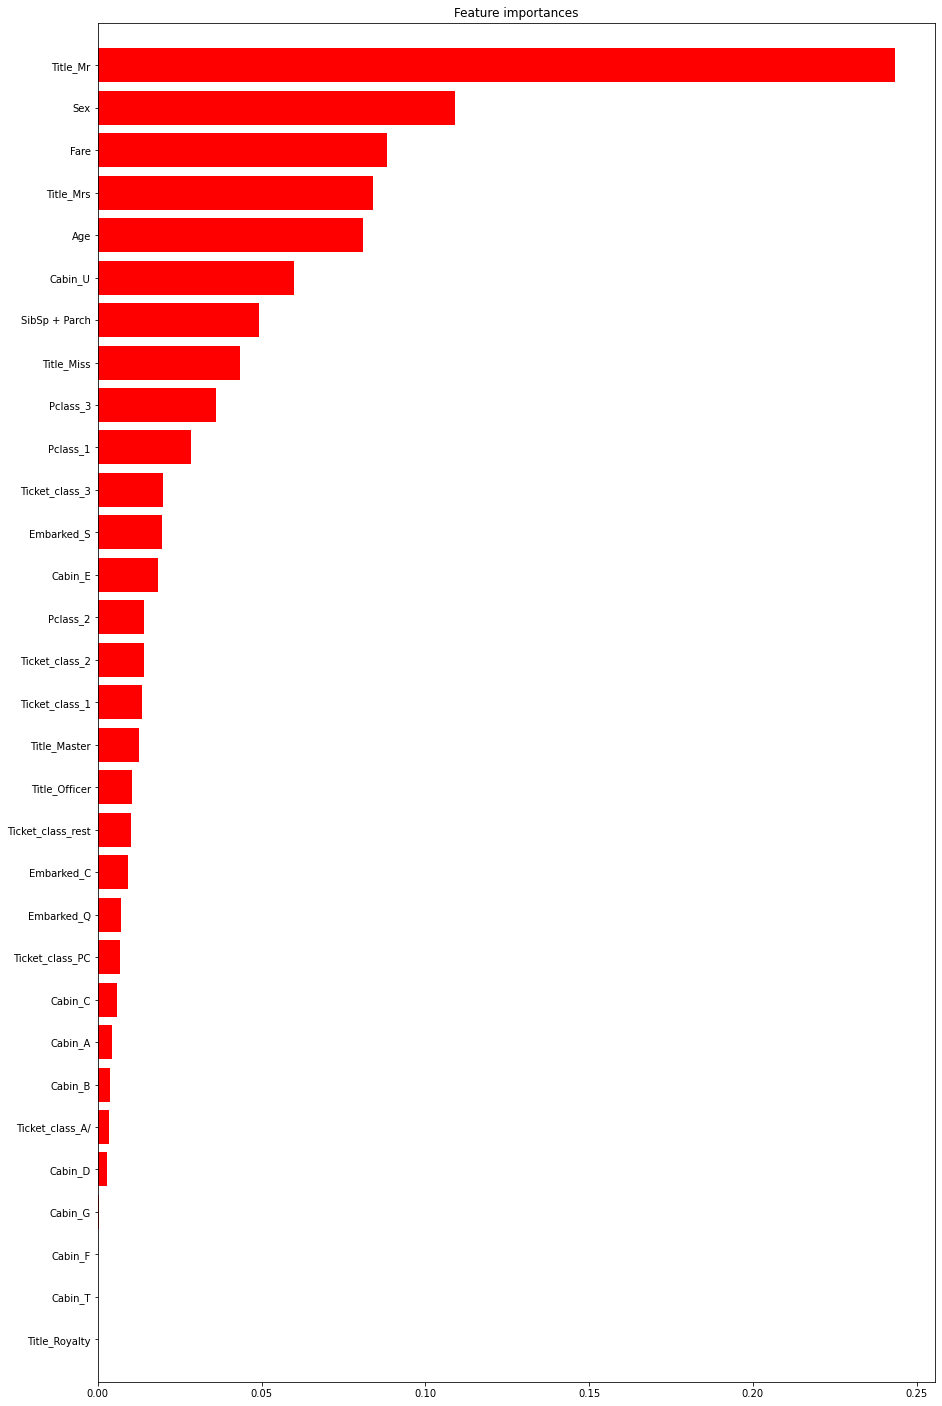

In [ ]:
importances = get_and_draw_importances(X_train, clf.feature_importances_)

**Final predictions**

In [ ]:
preds_test = clf.predict(X_test)

In [ ]:
PassengerId = pd.Series(data = test_df_preprocessed['PassengerId'], name = 'PassengerId')
Survived = pd.Series(data = preds_test, name = 'Survived')

In [ ]:
predictions = pd.concat([PassengerId, Survived], axis = 1).astype(int)

In [ ]:
predictions.to_csv('predicitons.csv', index=None)

In [ ]:
files.download('predicitons.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>